<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [45]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as cb
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

Проверим в хронологичном ли порядке расположены даты и посмотрим информацию о данных:

In [3]:
display(data.index.is_monotonic)
display(data.head(10))
data.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Сделаем ресемплирование с сумой заказов на каждый час по часам и посмотрим график:

<AxesSubplot:xlabel='datetime'>

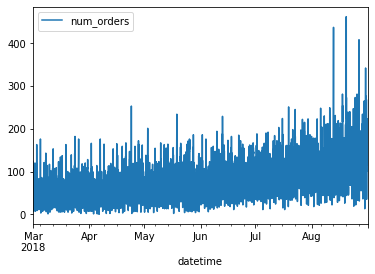

In [4]:
data=data.resample('1H').sum() 
data.plot()

Вывод:
Исходный датасет состоит из следующих столбцов: • datetime — дата и время заказа такси • num_orders — количество заказов такси (целевой признак) Количество строк в датасете 4416. Пропуски в данных отсутствуют.

Мы сделали предобработку данных и посмотрели на наши данные с количеством вызово за каждый час. Данные имеют большую частоту.

## Анализ

Найдем сначала лимиты 

In [5]:
print('Starting date:',data.index.min())
print('Ending date:',data.index.max())
print('Total time:',data.index.max() - data.index.min())
print()
data.describe()

Starting date: 2018-03-01 00:00:00
Ending date: 2018-08-31 23:00:00
Total time: 183 days 23:00:00



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные собраны за 183 дня и 23 часа. Минимальное количество заказов за 1 час: 0, а максимальное: 462.

Посмотрим на график вызовов по дням:

<AxesSubplot:xlabel='datetime'>

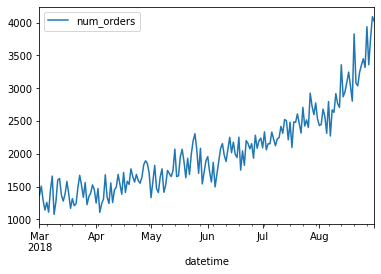

In [6]:
data.resample('1D').sum().plot() 

In [7]:
figsize = (21,4)

график ресемплированных данных за все месяцы

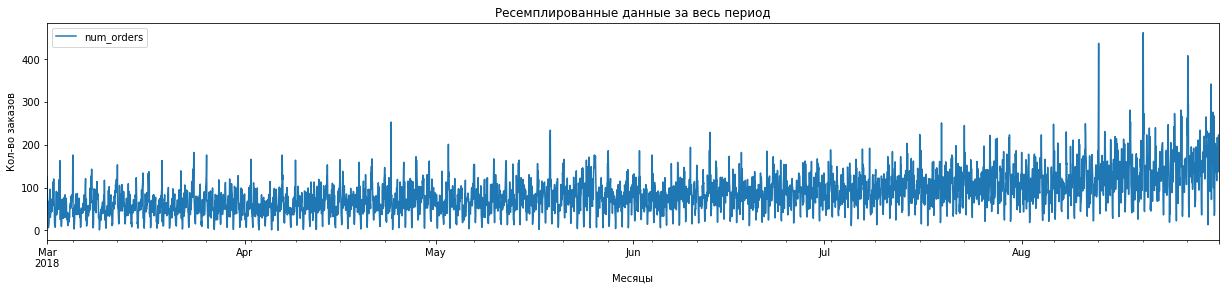

In [8]:
data.plot(figsize=figsize)
plt.title('Ресемплированные данные за весь период')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

график за август:

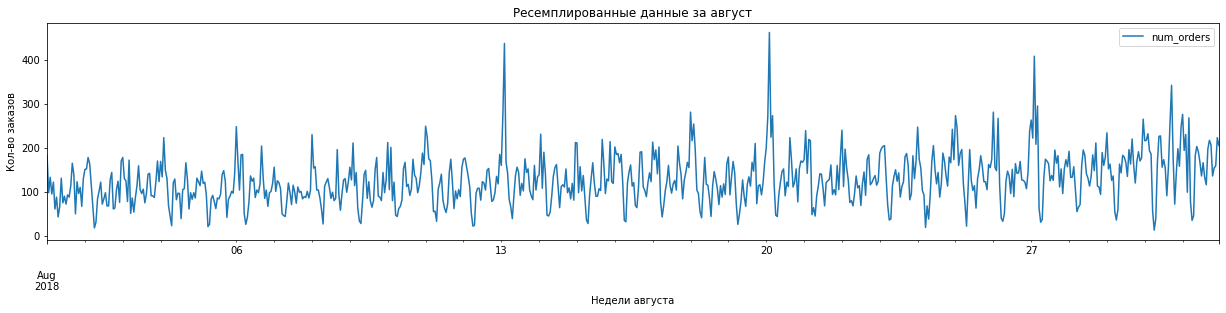

In [9]:
data_aug = data['2018-08-01':]
data_aug.plot(figsize=figsize)
plt.title('Ресемплированные данные за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

график за последнюю неделю августа:

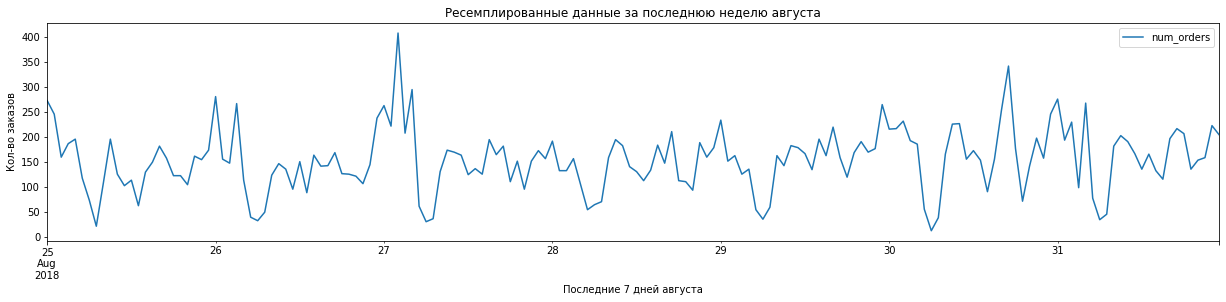

In [10]:
data_aug_7days = data['2018-08-25':]
data_aug_7days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последнюю неделю августа')
plt.xlabel('Последние 7 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

график за последние 3 дня августа:

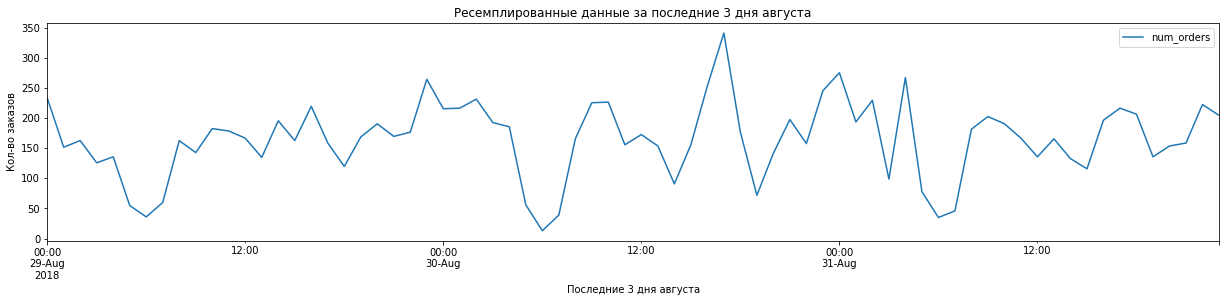

In [11]:
data_aug_3days = data['2018-08-29':]
data_aug_3days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последние 3 дня августа')
plt.xlabel('Последние 3 дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

На графике ресемплированных по 1 часу данных видно, что кол-во заказов начинает возрастать, при этом в августе всплески заказов по понедельникам
Видно падение заказов по утрам и затем подъем к 12:00

Посмотрим на скользящую среднюю по месяцам:

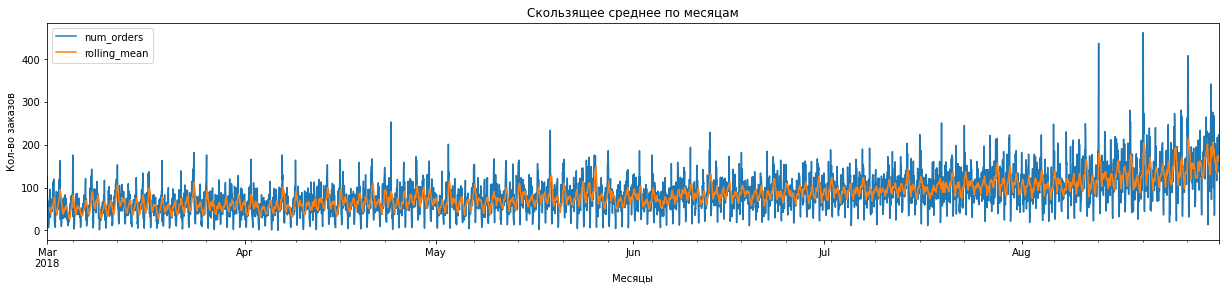

In [12]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot(figsize=figsize)
plt.title('Скользящее среднее по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Посмотрим на скользящую среднюю за август:

/tmp/ipykernel_31/4229001301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aug['rolling_mean'] = data_aug.rolling(10).mean()


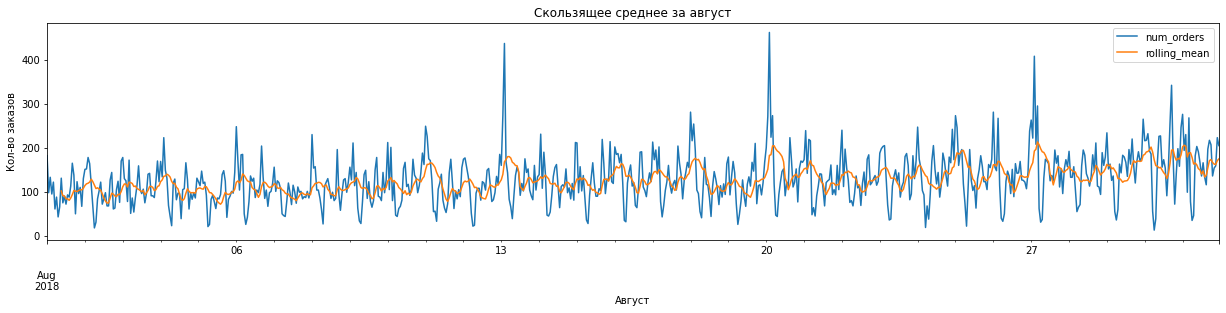

In [13]:
data_aug['rolling_mean'] = data_aug.rolling(10).mean()
data_aug.plot(figsize=figsize)
plt.title('Скользящее среднее за август')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.show()

Посмотрим на скользящую среднюю за последнюю неделю августа:

/tmp/ipykernel_31/238668789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aug_7days['rolling_mean'] = data_aug_7days.rolling(10).mean()


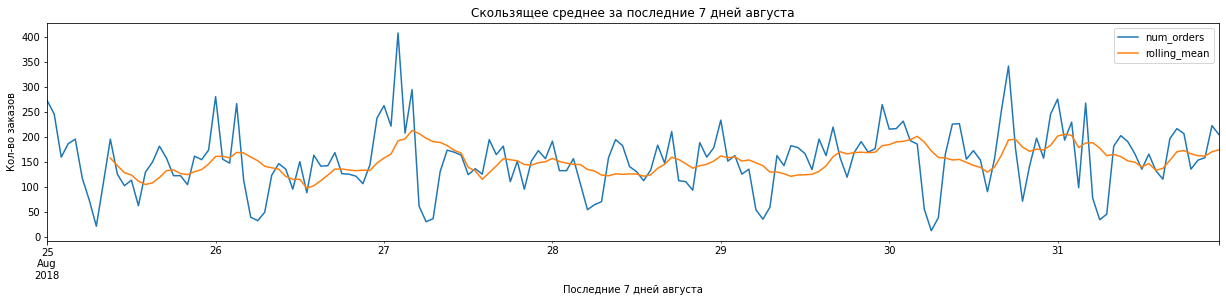

In [14]:
data_aug_7days['rolling_mean'] = data_aug_7days.rolling(10).mean()
data_aug_7days.plot(figsize=figsize)
plt.title('Скользящее среднее за последние 7 дней августа')
plt.xlabel('Последние 7 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

Посмотрим на скользящую среднюю за последние 3 дня августа:

/tmp/ipykernel_31/3321445166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aug_3days['rolling_mean'] = data_aug_3days.rolling(10).mean()


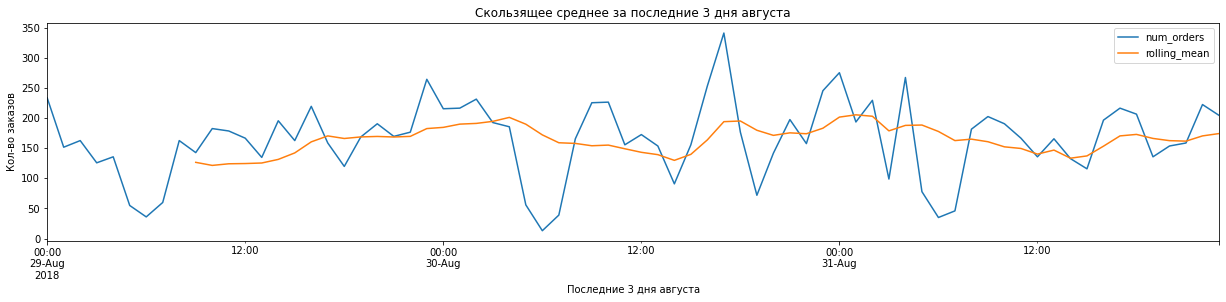

In [15]:
data_aug_3days['rolling_mean'] = data_aug_3days.rolling(10).mean()
data_aug_3days.plot(figsize=figsize)
plt.title('Скользящее среднее за последние 3 дня августа')
plt.xlabel('Последние 3 дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

Данные имеют большие колебания, но с помощью средней скользящей мы уже видим восхдящий тренд сползающий вверх  по месяцам, но за август он примерно с равными подъемами и спусками

Теперь проведем анализ временных рядов за весь период

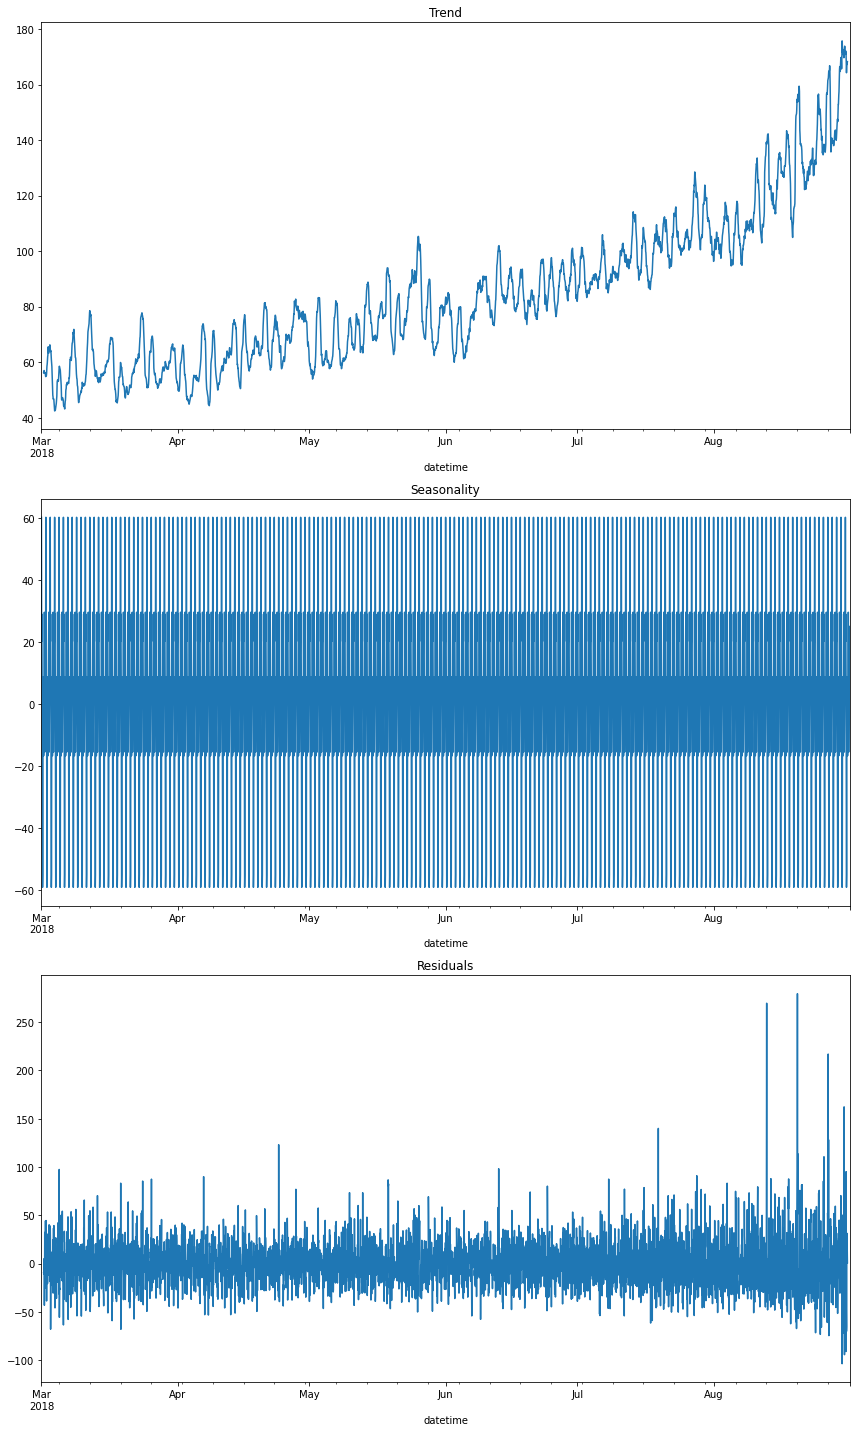

In [16]:
decomposed = seasonal_decompose(data.num_orders)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Теперь проведем анализ временных рядов за август

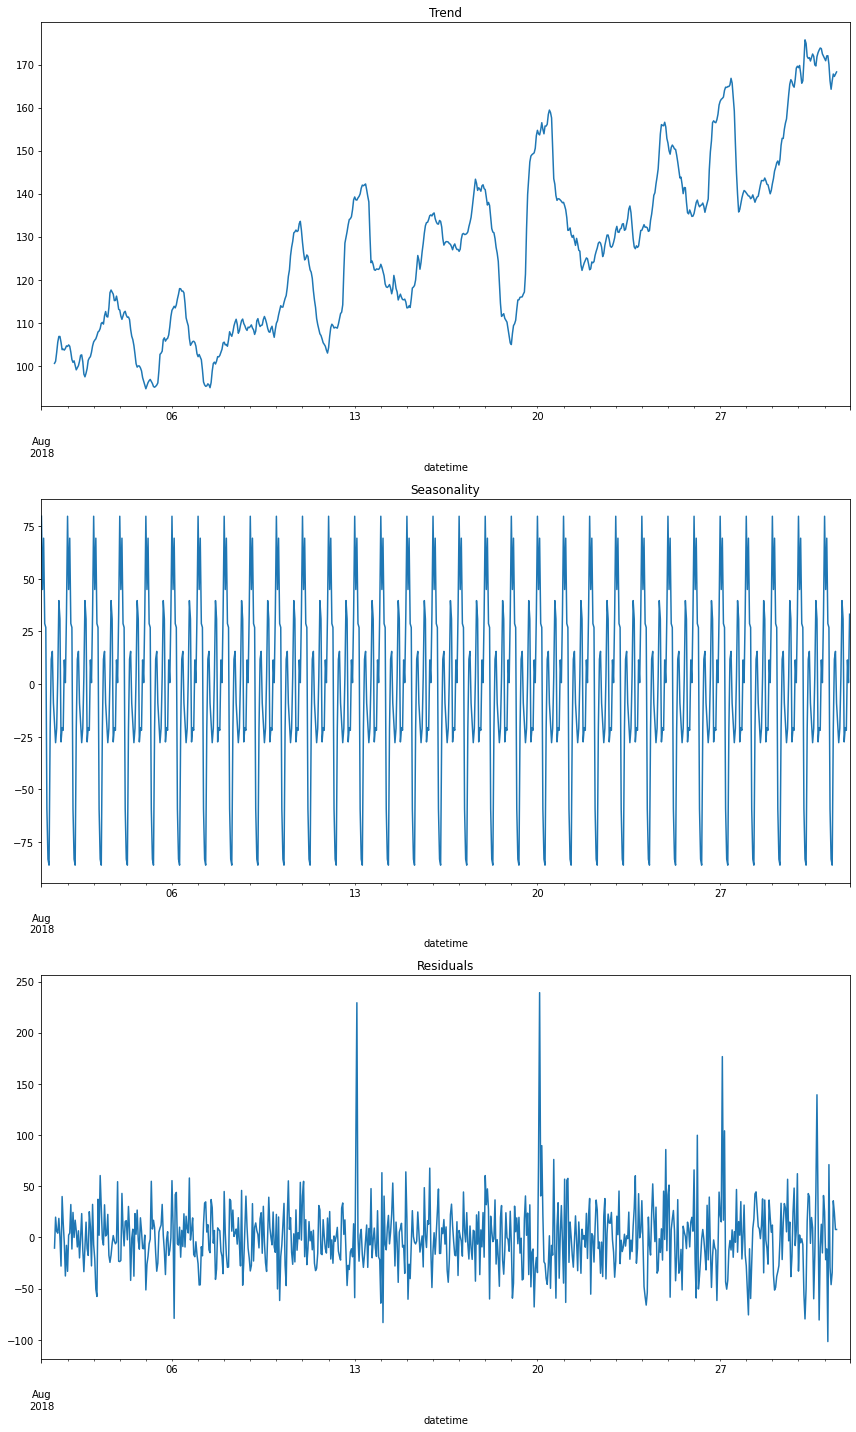

In [17]:
decomposed = seasonal_decompose(data_aug.num_orders)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Теперь проведем анализ временных рядов за неделю августа

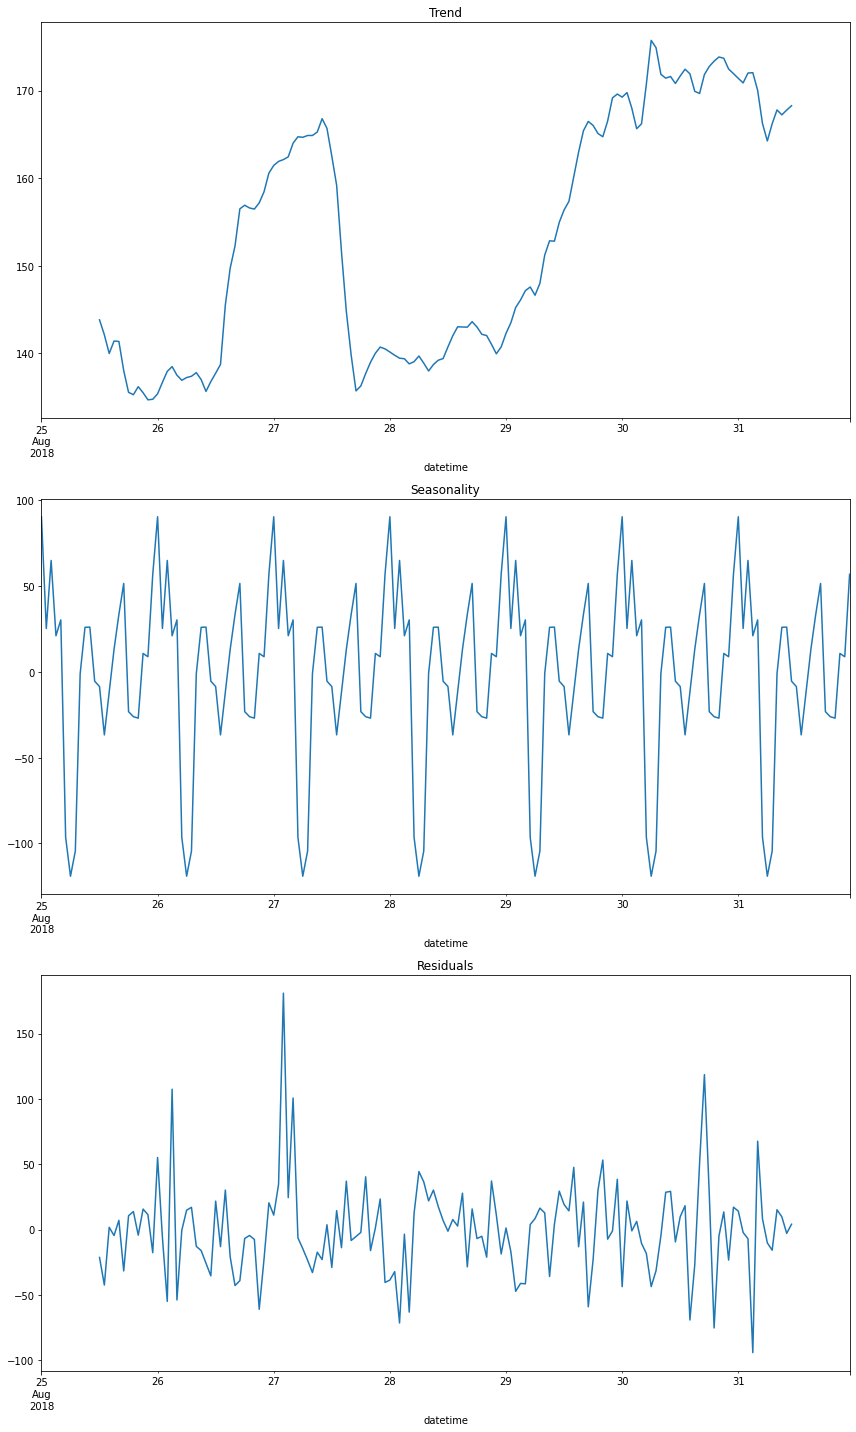

In [18]:
decomposed = seasonal_decompose(data_aug_7days.num_orders)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Теперь проведем анализ временных рядов за последние 3 дня

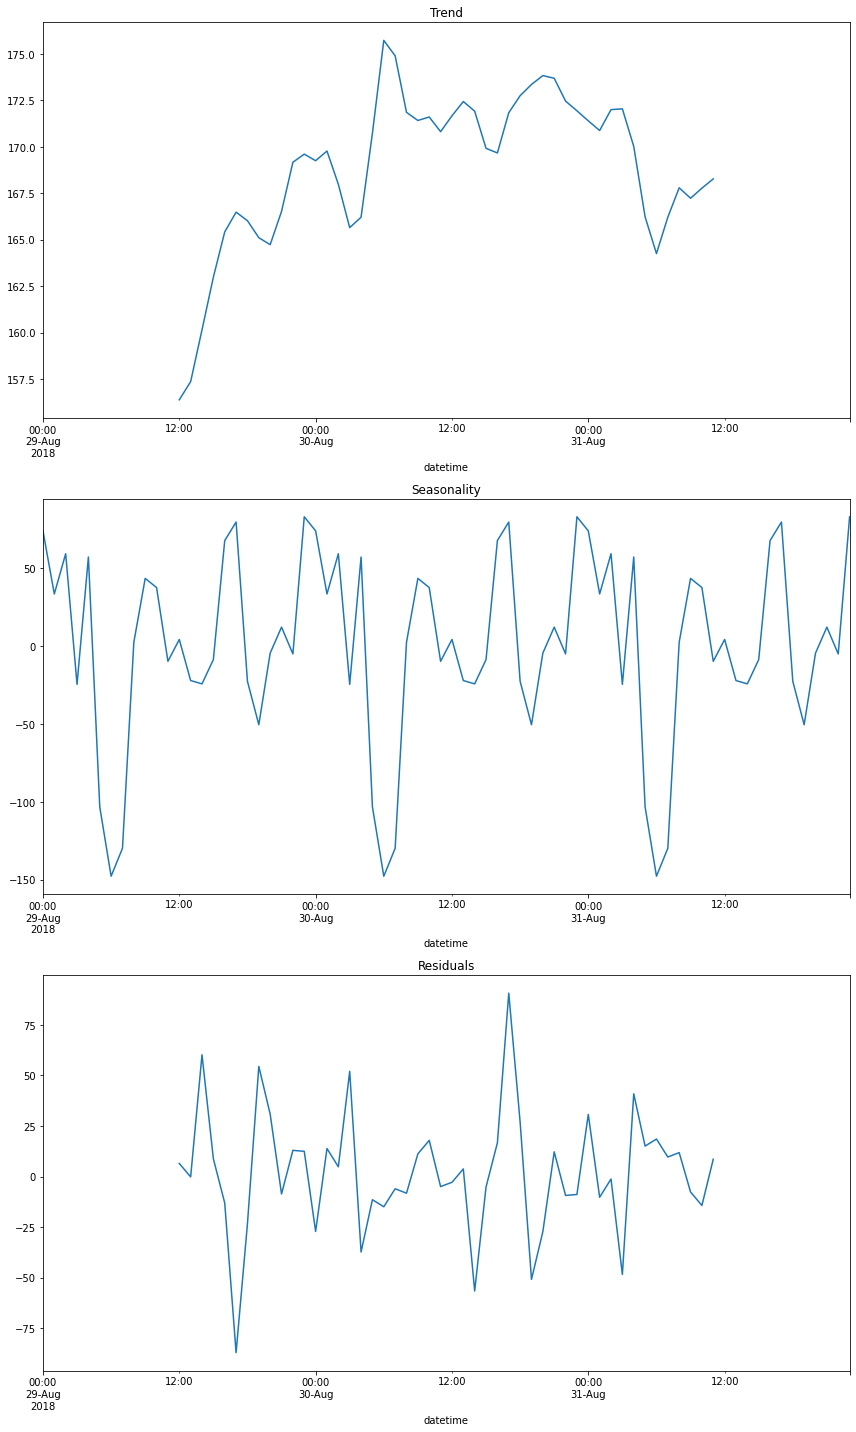

In [19]:
decomposed = seasonal_decompose(data_aug_3days.num_orders)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

<AxesSubplot:xlabel='datetime'>

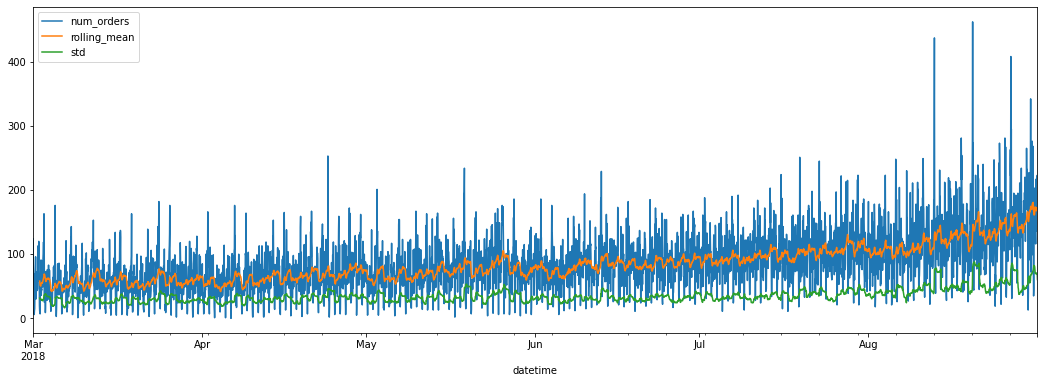

In [20]:
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot.rolling(30).mean()
data_plot['std'] = data_plot['num_orders'].rolling(30).std()
data_plot.plot(figsize=(18, 6))

<AxesSubplot:xlabel='datetime'>

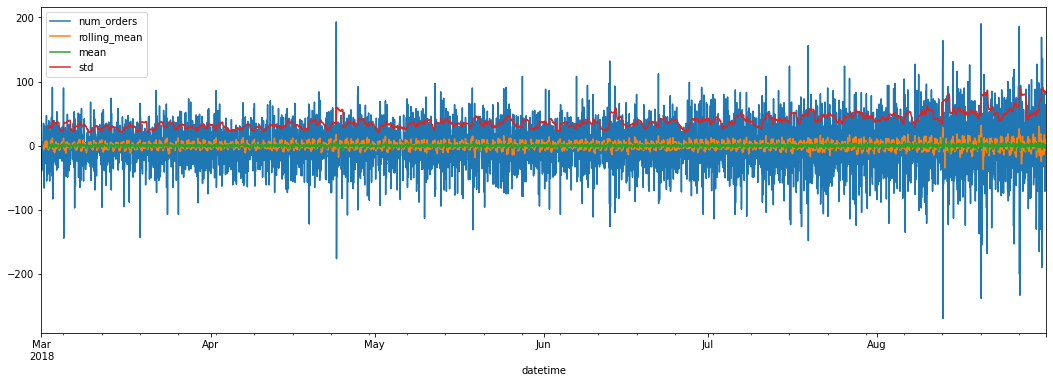

In [21]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(30).mean()
data_shift['std'] = data_shift['num_orders'].rolling(30).std()
data_shift.plot(figsize=(18, 6))

Вывод:
На этом этапе проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:

За время наблюдений наметился определенный тренд на общее увеличение заказов такси  к августу месяцу.

Количество заказов увеличивается в второй половине августа.

На последней неделе августа в последние 3 дня опять появился рост заказов. это обусловено тем, что начинается учебный год и многие возвращаются с отпусков или с каникул.

При анализе последних трех дней дней наблюдается одинаковая тенденция в зависимости от времени суток.

Количество заказов зависит от дня недели и времени суток.

## Обучение

Обучим три модели ориентируясь на метрику RMSE. В качестве моделей используем Линейную регрессию, Случайный лес и CatBoostRegressor.

In [22]:
#ввожу функцию признаков:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

Применим функцию с лагом до 24 часов и 10-м скользящим средним:

In [23]:
make_features(data, 168, 10)

Удалим пропуски и посмотрим данные:

In [24]:
data = data.dropna()

In [25]:
data.head()

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,74.2,3,0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-08 01:00:00,78,84.2,3,1,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-08 02:00:00,65,86.9,3,2,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-08 03:00:00,68,88.8,3,3,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-08 04:00:00,60,90.8,3,4,68.0,65.0,78.0,143.0,94.0,127.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


Поделим данные:

In [26]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [27]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3823, 171)
(425, 171)
(3823,)
(425,)


Пропишу функцию для расчета метрики RMSE:

In [28]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Линейная регрессия

В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().

In [29]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
#Обучаю модель
regression.fit(features_train, target_train)
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 23.18293269831032
CPU times: user 370 ms, sys: 659 ms, total: 1.03 s
Wall time: 1.01 s


Модель ансамблей - лес решений:

In [30]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
forest = RandomForestRegressor()
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

CPU times: user 23min 25s, sys: 2.68 s, total: 23min 28s
Wall time: 23min 29s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f0728549900>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [31]:
%%time
forest_params=forest_grid.best_params_
fbs=forest_grid.best_score_*(-1)
print(forest_grid.best_estimator_)
print(forest_grid.best_params_)
print('Качество модели на кросс-валидации', fbs)

RandomForestRegressor(max_depth=13, min_samples_leaf=2, n_estimators=25)
{'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}
Качество модели на кросс-валидации 23.785825633280336
CPU times: user 705 µs, sys: 3 µs, total: 708 µs
Wall time: 543 µs


Модель градиентного бустинга - CatBoost:

In [32]:
%%time

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
cb = cb.CatBoostRegressor()
#Определяю словарь с набором параметров
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 29.1661652	total: 59.4ms	remaining: 59.4s
100:	learn: 16.2986618	total: 1.05s	remaining: 9.38s
200:	learn: 14.4616565	total: 2.14s	remaining: 8.49s
300:	learn: 13.2101386	total: 3.17s	remaining: 7.37s
400:	learn: 11.8153583	total: 4.23s	remaining: 6.32s
500:	learn: 10.7623487	total: 5.28s	remaining: 5.26s
600:	learn: 9.8950124	total: 6.33s	remaining: 4.2s
700:	learn: 9.0944503	total: 7.34s	remaining: 3.13s
800:	learn: 8.3172396	total: 8.36s	remaining: 2.08s
900:	learn: 7.6330566	total: 9.36s	remaining: 1.03s
999:	learn: 7.0103027	total: 10.4s	remaining: 0us
0:	learn: 32.5457133	total: 23.4ms	remaining: 23.3s
100:	learn: 18.1137993	total: 1.3s	remaining: 11.6s
200:	learn: 16.5825372	total: 2.5s	remaining: 9.96s
300:	learn: 15.6022377	total: 3.73s	remaining: 8.66s
400:	learn: 14.6972707	total: 4.95s	remaining: 7.39s
500:	learn: 13.8721817	total: 6.16s	remaining: 6.14s
600:	learn: 13.1976516	total: 7.35s	remaining: 4.88s
700:	learn: 12.5474548	total: 8.6s	remaining: 3.67s
800:	l

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f07285497b0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f072844fcd0>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [33]:
%%time
cb_params=cb_grid.best_params_
cbs=cb_grid.best_score_*(-1)
print(cb_grid.best_estimator_)
print(cb_grid.best_params_)
print('Качество модели на кросс-валидации', cbs)

{'depth': 4, 'learning_rate': 0.03}
Качество модели на кросс-валидации 23.51481193396812
CPU times: user 1.16 ms, sys: 0 ns, total: 1.16 ms
Wall time: 1.09 ms


Вывод :
Мы обучили 3 модели и подобрали гиперпараметры методом грид серч. Лучшей себя показала модель Линейная регрессия

## Тестирование

Тест на адекватность модели:

In [34]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 58.82


Модель линейной регрессии:

In [35]:
%%time
#Обучаю модель
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

#Определяю метрику RMSE
regression_RMSE = round(RMSE(target_test, regression_model_predictions), 3)
print('RMSE модели Линейной регрессии:', regression_RMSE)

RMSE модели Линейной регрессии: 34.26
CPU times: user 774 ms, sys: 2.4 s, total: 3.18 s
Wall time: 3.15 s


Пропишем функцию для построения сравнительных графиков "целевой признак - предсказание модели":

In [36]:
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    model_data['2018-08-01':'2018-08-31'].plot(figsize=(18, 6))

Сравниваю наши данные и что мы предсказали по графику:

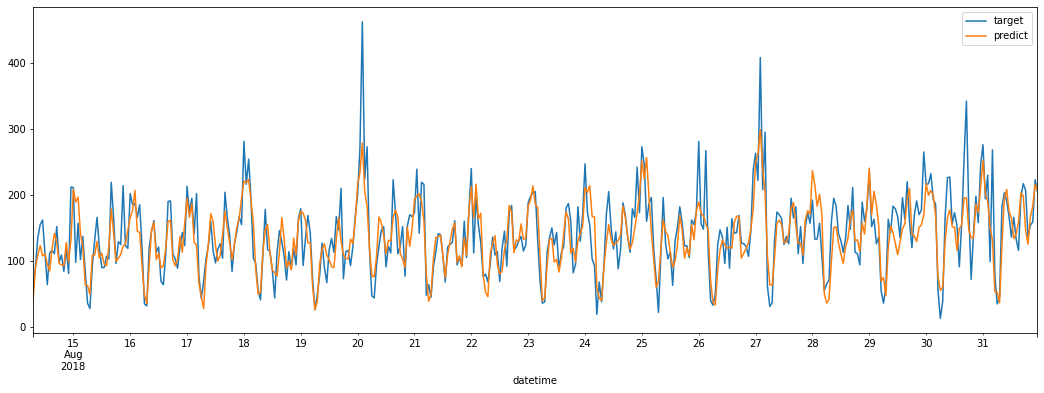

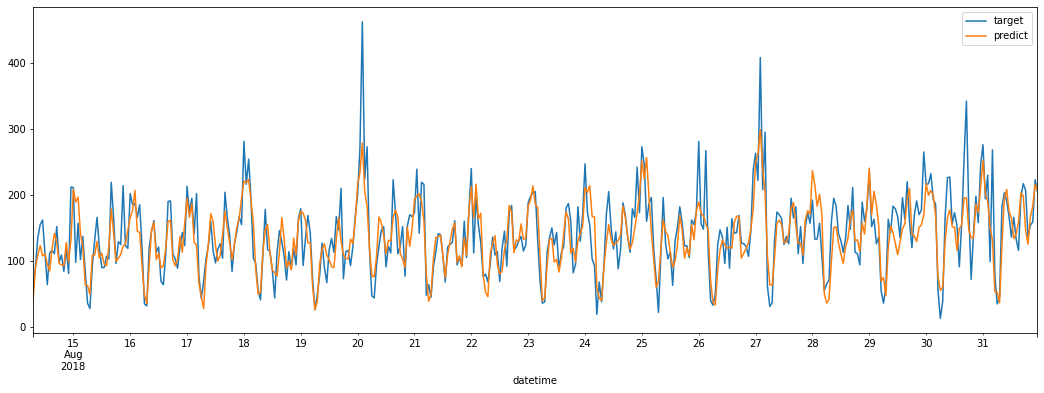

In [37]:
graphicaizer(regression_model_predictions)

Модель ансамблей - лес решений:

In [38]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

#Определяю метрику RMSE
forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 38.967
CPU times: user 7.21 s, sys: 40 ms, total: 7.25 s
Wall time: 7.29 s


Сравниваю наши данные и что мы предсказали по графику:

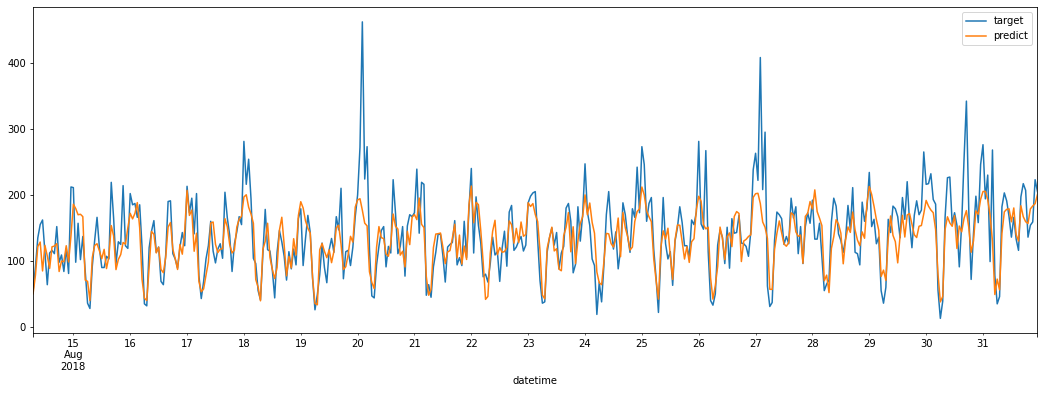

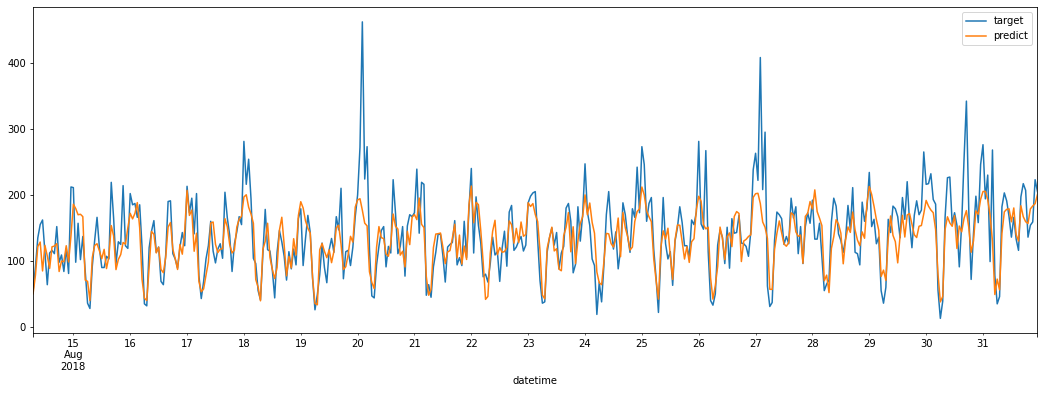

In [39]:
graphicaizer(forest_model_predictions)

Объявляю функцию для построения графика важности признаков, она будет показывать только те признаки,важность которых больше 0.0:

In [51]:
def feature_importance_hist(model, features_train):
    importances = list(model.feature_importances_)
    names_indices = features_train.columns
    not_null_importances = []
    not_null_indices = []

    for i in importances:
        if i>0:
            not_null_importances.append(i)
            not_null_indices.append(names_indices[importances.index(i)])
    
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances")
 
    plt.bar(range(len(not_null_importances)), not_null_importances, color="g")
    plt.xticks(range(len(importances)), names_indices, rotation=90)
    plt.tight_layout()
    plt.xlim([-1, len(not_null_importances)])
    plt.show()

Строю график важности признаков модели:

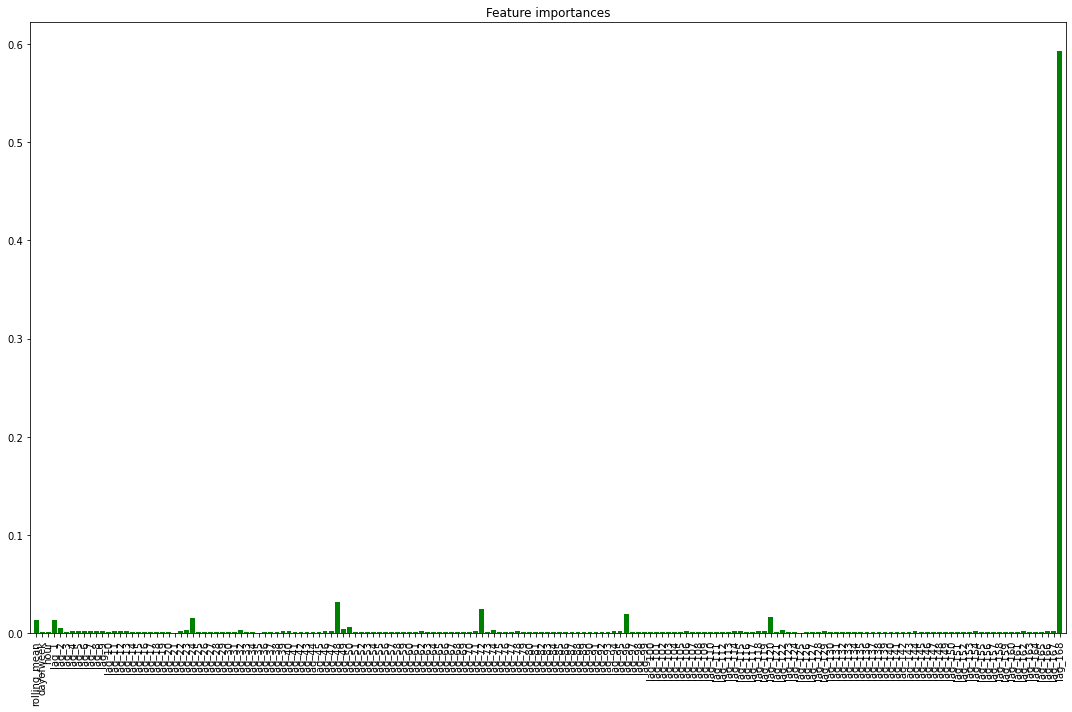

In [52]:
feature_importance_hist(forest_model, features_train)

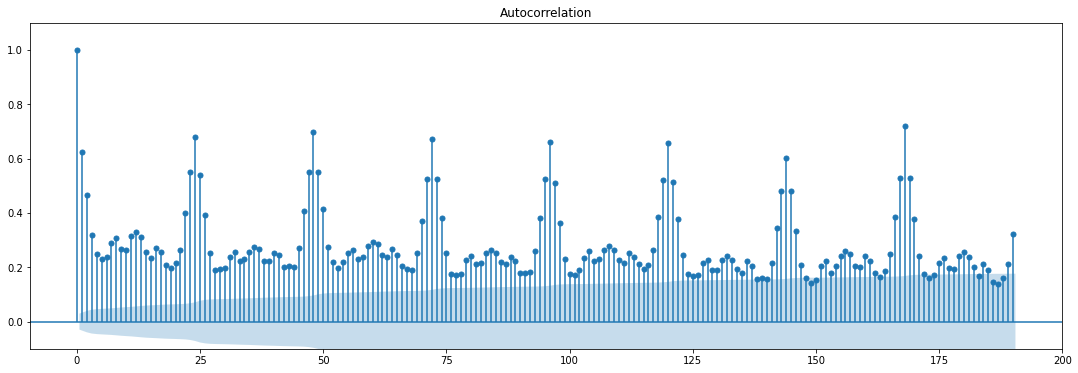

In [42]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



Модель градиентного бустинга - CatBoost:

In [46]:
%%time

#Обучаю модель на оптимальных гиперпараметрах
cb_model = cb.CatBoostRegressor(learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)

#Определяю метрику RMSE
cb_RMSE = round(RMSE(target_test, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

0:	learn: 38.2616489	total: 15.9ms	remaining: 15.9s
100:	learn: 21.3074941	total: 1.7s	remaining: 15.1s
200:	learn: 20.1453691	total: 3.31s	remaining: 13.2s
300:	learn: 19.5011428	total: 4.97s	remaining: 11.5s
400:	learn: 18.7390080	total: 6.88s	remaining: 10.3s
500:	learn: 18.0633593	total: 8.57s	remaining: 8.53s
600:	learn: 17.5130042	total: 10.3s	remaining: 6.86s
700:	learn: 17.0400652	total: 12.1s	remaining: 5.16s
800:	learn: 16.5362451	total: 14s	remaining: 3.47s
900:	learn: 16.0694645	total: 15.8s	remaining: 1.73s
999:	learn: 15.6505970	total: 17.5s	remaining: 0us
RMSE модели CatBoostRegressor: 36.606
CPU times: user 17.4 s, sys: 144 ms, total: 17.6 s
Wall time: 19.2 s


Сравниваю наши данные и что мы предсказали по графику:

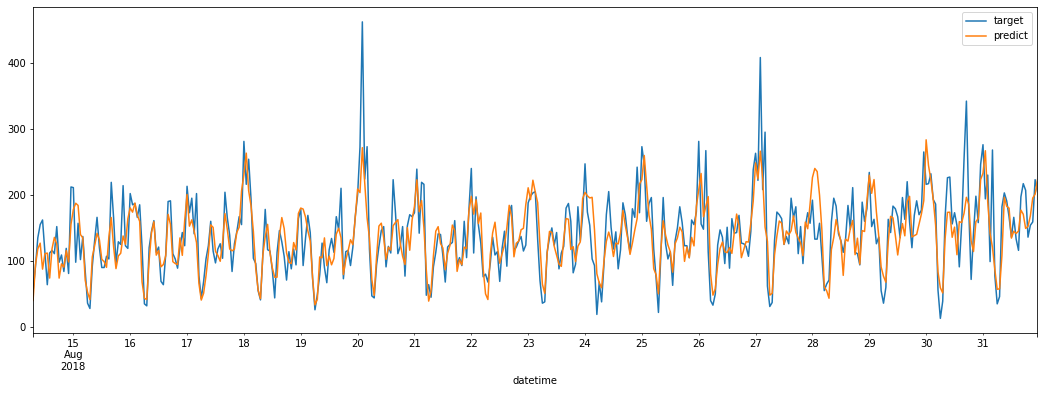

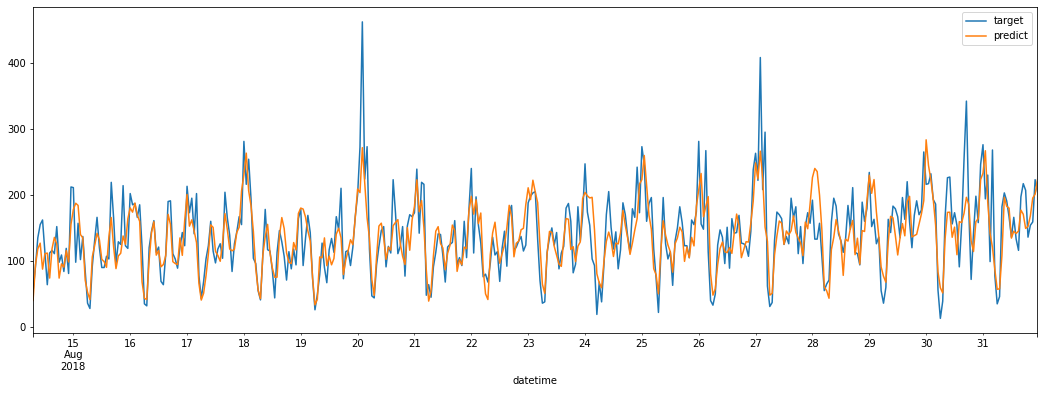

In [47]:
graphicaizer(cb_model_predictions)

Строю график важности признаков модели:

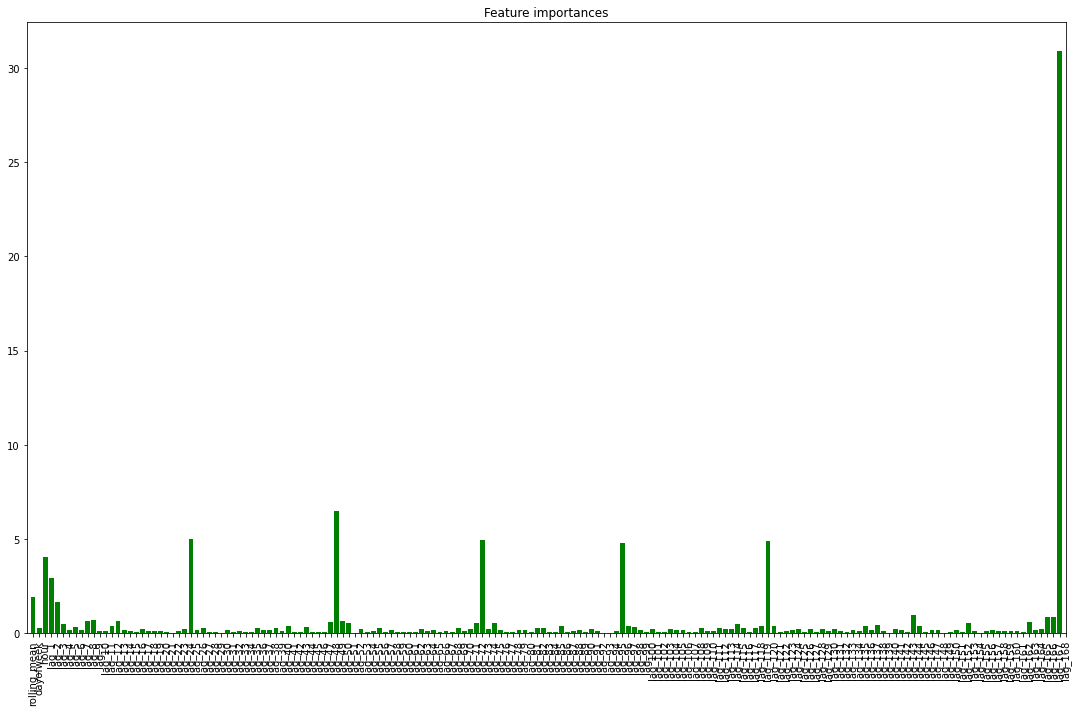

In [53]:
feature_importance_hist(cb_model, features_train)

Cмотрим итоговые RMSE для каждой модели, наилучшей будет та модель у которой отклонение минимально:

In [54]:
print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))
print('RMSE модели Линейной регрессии:', regression_RMSE)
print('RMSE модели Случайного леса:', forest_RMSE)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

RMSE для проверки модели на адекватность: 58.82
RMSE модели Линейной регрессии: 34.26
RMSE модели Случайного леса: 38.967
RMSE модели CatBoostRegressor: 36.606


In [55]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor']
data = {'RMSE на CV':[regression_cv_score,
                      fbs,
                      cbs],
        'RMSE модели на тестовой выборке':[regression_RMSE,
                                           forest_RMSE,
                                           cb_RMSE]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE на CV'] = (scores_data['RMSE на CV'].min() /
                              scores_data['RMSE на CV'])
scores_data['Выполнение задачи'] = scores_data['RMSE модели на тестовой выборке'] < 48.0
scores_data

,RMSE на CV,RMSE модели на тестовой выборке,Рейтинг RMSE на CV,Выполнение задачи
LinearRegression,23.182933,34.260,1.000000,True
RandomForestRegressor,23.785826,38.967,0.974653,True
CatBoostRegressor,23.514812,36.606,0.985886,True


В лидерах у нас модель Линейная регрессия с RMSE = 34,260 на тестовой выборке и RMSE на кросс - 23,18

# Общий вывод:

При выполнении проекта проделана следующая работа:

На первом этапе произведена загрузка данных и их подготовка для обучения моделей.:

На втором этапе проведен анализ. За время наблюдений наметился определенный тренд на общее увеличение заказов такси к августу месяцу. А при анализе августа ко второй половине августа, т.е. когда приближается начало учебного года.

На третьем этапе к датасету были добавлены дополнительные признаки, а именно день недели, "отстающие значения" и скользящее среднее. На дополнном датасете подобраны оптимальные гиперпараметры для моделей.

На четвертом этапе проведено тестирование всех моделей, каждой из них удалось достичь требуемого показателя метрики RMSE. Анализ сравнительных графиков в двух масштабах, показал, что модели хуже всего справляются с предсказаниями на высоких пиках и на провалах, но в целом, угадывают направления движения. Наилучший показатель RMSE в данном случае у Линейной регресси = 34,260.

Соответственно для аэропорта актуальна сезонность. На высоком спросе предсказания получаются занижены, но тоже показывают пик. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48